## D213 Advanced Data Analytics PA 1
##### Submitted By Edwin Perry
### Table of Contents
<ol>
    <li><a href="#A">Research Question</a></li>
    <li><a href="#B">Technique Justification</a></li>
    <li><a href="#C">Data Preparation</a></li>
    <li><a href="#D">Analysis</a></li>
    <li><a href="#E">Data Summary and Implications</a></li>
    <li><a href="#F">Sources</a></li>
</ol>
<h4 id="A">Research Question</h4>
<h5>Question</h5>
<p>The research question I decided to address in this report is "Can I accurately forecast company revenue using time series analysis in the WGU provided telecommunications dataset?"</p>
<h5>Objectives/Goals</h5>
<p>The goal for this analysis is to accurately forecast the company revenue based on the data included within the csv file. As I do not have distinct datasets provided, showing progression over time, I will instead elect to split my dataset into 2 datasets: a training set consisting of 80% of the dataset, and a test set containing 20% of the dataset. The training set will be used to create the ARIMA time series model, then test set will be used to evaluate the performance. The goal of this is to generate a model that can accurately predict customer revenue</p>
<h4 id="4">Assumption</h4>
<h5>Time Series Assumption</h5>
<p>There are a number of assumptions that must be made for a time series analysis to be a valid analytical practice:
<ul>
<li>The data provided must be stationary. That is, the data cannot be influenced by trends or seasonality, and the mean and variance stay approximately constant over time</li>
<li>The data provided must not suffer from autocorrelation. This means that the entries in earlier rows or times cannot influence the results from future times/rows</li>
</ul>
</p>
<h4 id="C">Data Preparation</h4>
<h5>Time Series Visualization</h5>
<p>Before we begin the analysis, it is important to understand the underlying data. As such, we will start by visualizing how the data changed over time</p>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv('./s8dj4edjf84hd8fcvn3d/teleco_time_series .csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


<p>Here, we can see that the dataset consists of 2 columns: a day index that stores the count of days that have passed as an integer, and a revenue column that stores the revenue generated in a float. Now that we know the structure of the data source, we can create the graph. We will also convert the Day column to specific dates, for later usage.</p>

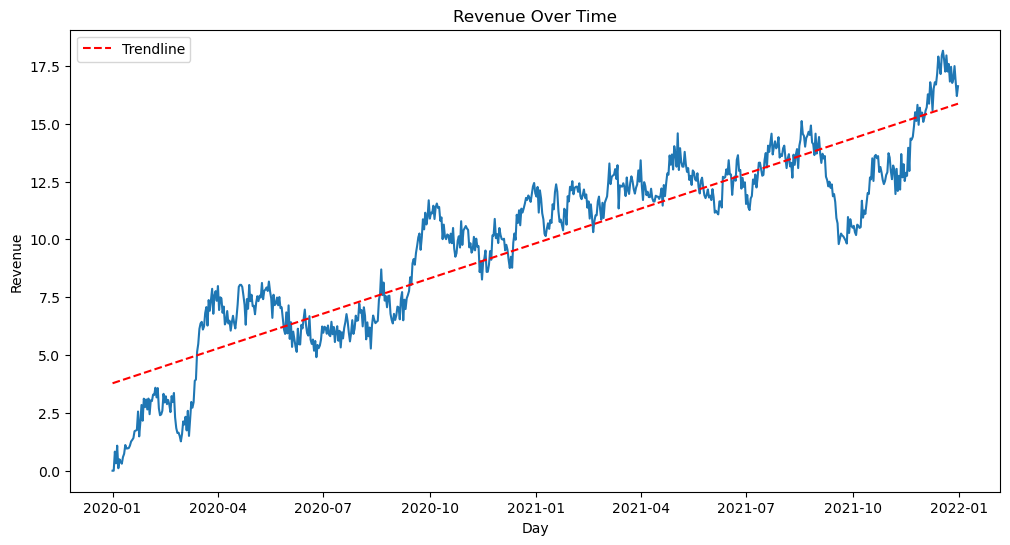

In [24]:
df['Day'] = pd.to_datetime('2020-01-01') + pd.to_timedelta(df['Day'] - 1, unit='D')
# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Revenue'])
x = mdates.date2num(df.Day)
# Adding a trendline
z = np.polyfit(x, df['Revenue'], 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Trendline')

# Adding labels and title
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.title('Revenue Over Time')
plt.legend()
plt.show()


<h5>Time Step Formatting</h5>
<p>This time series consists of a Day column that denotes the passage of time. This index increments by a single day for every observation. The column contains no gaps, and continues for 731 datapoints. This means that the analysis covers 2 years and 1 day, or 2 years exactly if one of the years is a leap year.</p>
<h5>Evaluating Stationarity</h5>
<p>The data, as observed above, is certainly not stationary. Instead, we have a trend that shows a demonstrable upward trend, indicating that the telecommunications company is generating more revenue as time progresses. As such, the time series analysis is not ideal for analyzing this data until there is further preparation</p>
<h5>Data Preparation</h5>
<p>There are 2 primary steps that need to be performed to prepare the data for analysis.
<ol>
<li>The data needs to be convered into a manner that is stationary, as we have already mentioned stationarity as a prerequisite for time series analysis</li>
<li>The data needs to be separated into training and testing datasets, which will allow us to both create the model and validate the results</li>
</ol>
We will start by using the Augmented Dicky-Fuller analysis to test the ADF score and the p-value, which is a metric that allows us to numerically determine stationarity. If the p-value is below 0.05, we will consider the data to be stationary.</p>

In [25]:
result = adfuller(df["Revenue"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")


if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is NOT stationary. Consider differencing.")

ADF Statistic: -1.924612157310181
P-Value: 0.3205728150793977
The data is NOT stationary. Consider differencing.


<p>The above data confirms, as we initially observed, that the data is not naturally stationary. Below, we will perform the differentiation that enforces the stationarity</p>

In [26]:
df["Revenue_Diff"] = df["Revenue"].diff().dropna()
result = adfuller(df["Revenue_Diff"].dropna())
print(f"New ADF Statistic: {result[0]}")
print(f"New P-Value: {result[1]}")

if result[1] < 0.05:
    print("The data is now stationary.")
else:
    print("Further differencing or transformations may be needed.")


New ADF Statistic: -44.874527193875984
New P-Value: 0.0
The data is now stationary.


<p>We now have stationary data with a p-value of 0. This has required the removal of the first row, as there is no value to compare this row to, which is why we use the dropna() method above. We can also visualize the results of this differentiation below.</p>

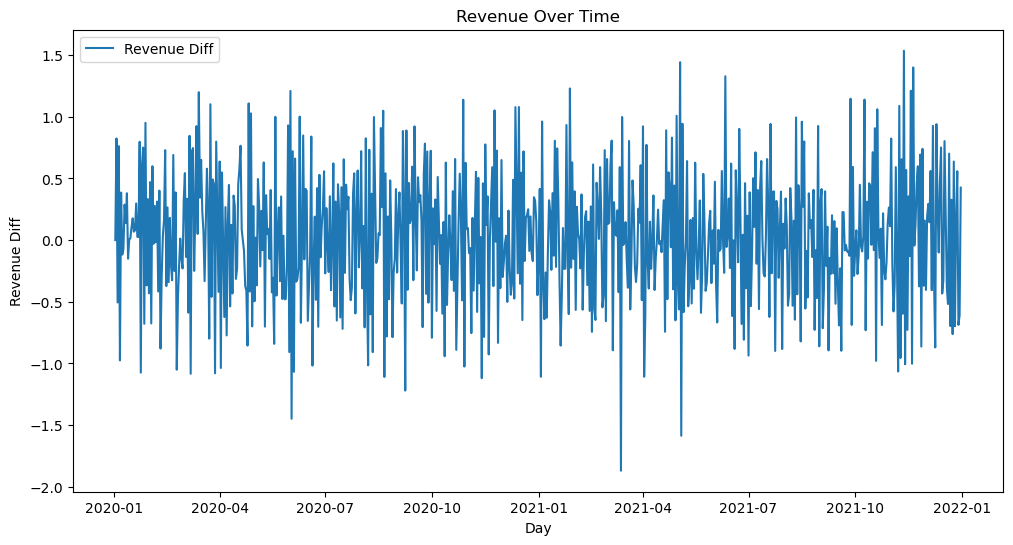

In [27]:
# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Revenue_Diff'], label='Revenue Diff')

# Adding a trendline
z = np.polyfit(x, df['Revenue_Diff'], 1)
p = np.poly1d(z)
# Adding labels and title
plt.xlabel('Day')
plt.ylabel('Revenue Diff')
plt.title('Revenue Over Time')
plt.legend()
plt.show()

<p>With stationarity established, we can proceed to split the data into test and training sets. Each of these datasets will be submitted alongside this Jupyter Notebook.</p>

In [28]:
# Selecting the relevant columns
df_subset = df[['Day', 'Revenue_Diff']].dropna()
df_subset.set_index('Day', inplace=True)
# Splitting the data into training and testing sets
train, test = train_test_split(df_subset, test_size=0.2, random_state=42, shuffle=False)

print("Training Set:")
print(train.head())
print("\nTesting Set:")
print(test.head())

Training Set:
            Revenue_Diff
Day                     
2020-01-02      0.000793
2020-01-03      0.824749
2020-01-04     -0.505210
2020-01-05      0.762222
2020-01-06     -0.974900

Testing Set:
            Revenue_Diff
Day                     
2021-08-08     -0.531923
2021-08-09      0.157387
2021-08-10     -0.644689
2021-08-11      0.995057
2021-08-12     -0.438775


<h5>Copy of Dataset</h5>
<p>The cleaned dataset will be provided alongside this submission. It will include the cleaned data immediately prior to the data split and immediately after.</p>

In [29]:
train.to_csv('P1_train_cleaned.csv')
test.to_csv('P1_test_cleaned.csv')
df_subset.to_csv('P1_cleaned.csv')

<h4 id="D">Model Identification and Analysis</h4>
<h5>Reported Findings</h5>
<p>At this point, it is worth looking into a number of different aspects looking into the data. First, we will look at seasonality</p>

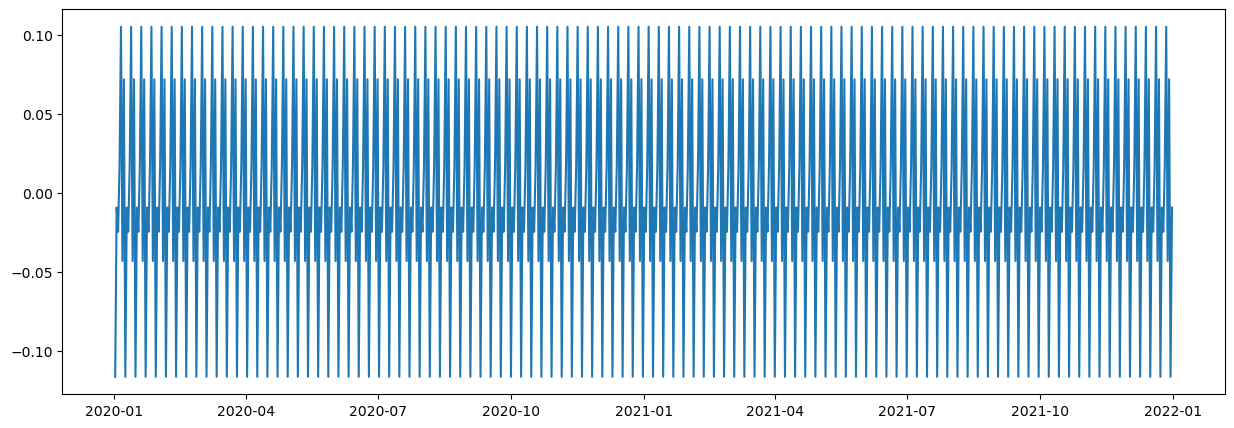

In [30]:
decomposed_df = seasonal_decompose(df_subset)
plt.figure(figsize=[15, 5])
plt.plot(decomposed_df.seasonal)

<p>Above, we can see that there is a seasonal pattern, with these sudden rises and drops in out Revenue_Diff column. The magnitude of this seasonality, though, is always between -0.12-0.12, indicating that the effect that this seasonal pattern is not necessarily incredibly strong. This seasonality seems to occur multiple times within one month, so it can be assumed that the revenue change is likely tied to a particular day of the week. We can confirm this by limiting the data to one month and analyzing it in greater detail</p> 

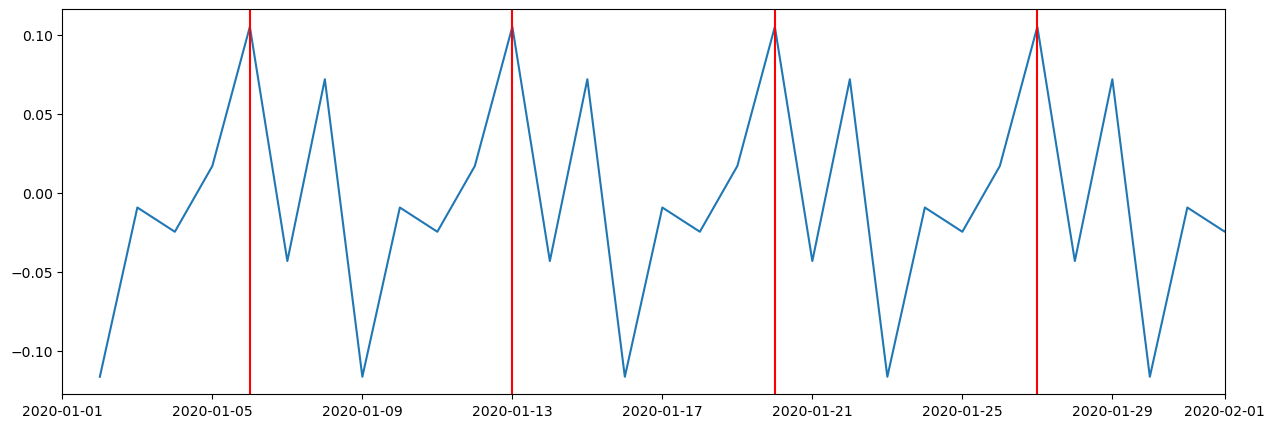

In [31]:
plt.figure(figsize=[15, 5])
plt.plot(decomposed_df.seasonal)
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-02-01'))
plt.axvline(x=pd.to_datetime('2020-01-06'), color='red')
plt.axvline(x=pd.to_datetime('2020-01-13'), color='red')
plt.axvline(x=pd.to_datetime('2020-01-20'), color='red')
plt.axvline(x=pd.to_datetime('2020-01-27'), color='red')

<p>Above, we can see that the seasonality is, in fact, weekly in nature, with peaks occuring every Monday. In other words, we expect a sudden increase in revenue every Monday, compared to the day before.<br /></p>
<p>Another important aspect to investigate is the presence of trends. We would not expect any trends, as we have already attempted taken action to make the data stationary. Even so, we will create a visualization below to validate.</p>

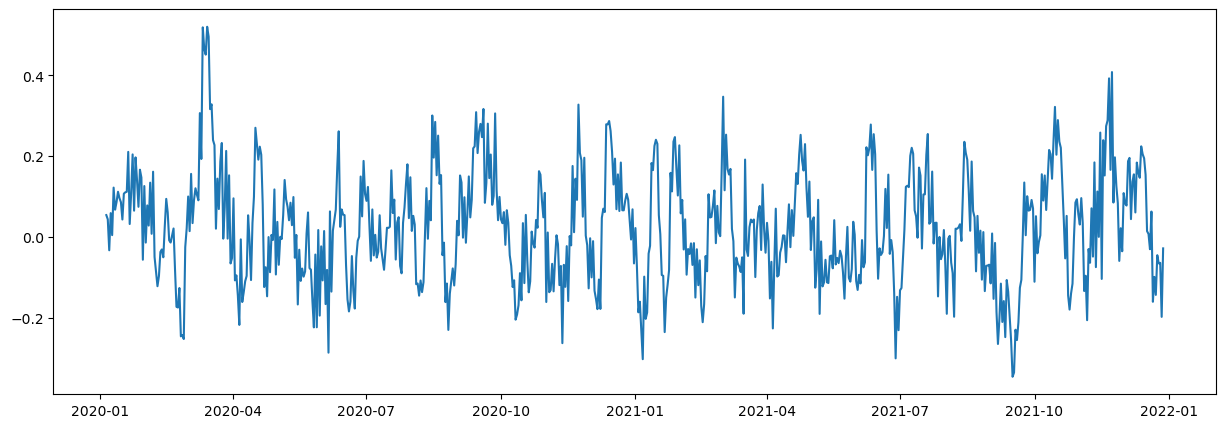

In [32]:
plt.figure(figsize=[15, 5])
plt.plot(decomposed_df.trend)

<p>As predicted, we see no apparent overall trend over the entirety of the period that the data covers.</p>
<p>The next factor to look into is autocorrelation. We can utilize the ACF and PACF to determing whether this data is an autoregression model or a moving average model.</p>

(-0.6, 0.6)

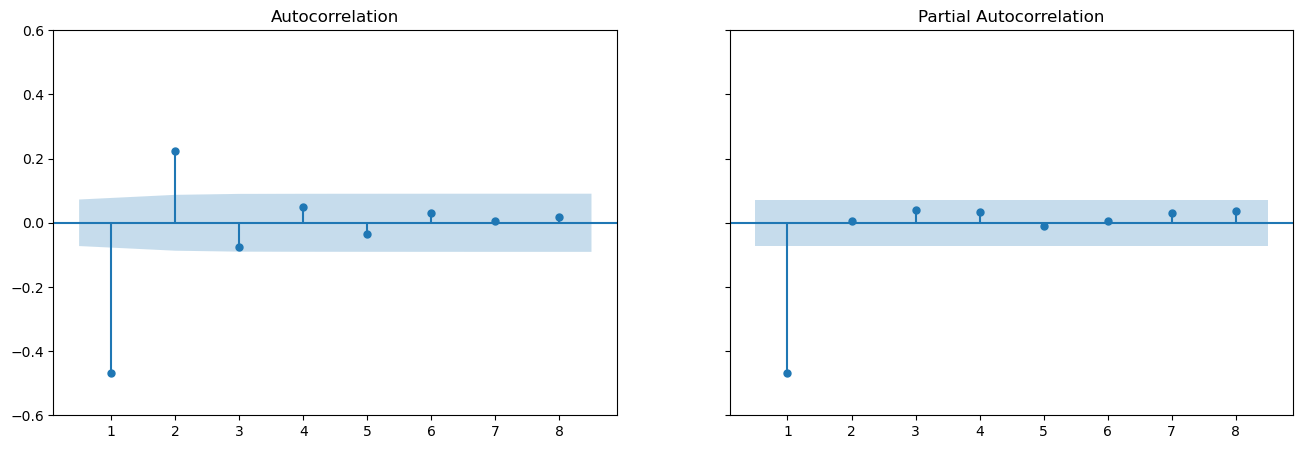

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5], sharey=True)
plot_acf(df_subset, lags=8, zero=False, ax=ax1)
plot_pacf(df_subset, lags=8, zero=False,ax=ax2)
plt.ylim(-0.6, 0.6)

<p>The shaded area above represents statistically insignificant results that are not useful in our analysis. The ACF is reduced at 2, and completely cuts off later than that point. PACF, though, completely cuts off after 1. Therefore, the ideal model to use for this analysis will be an AR(1) model.</p>
<p>The next factor to consider is the spectral density (or Power Spectral Density, PSD). This factor shows how the variance is distributed across different frequencies, helping to identify periodic patterns.</p>

(array([6.97387711e+03, 3.91439441e+03, 5.47611144e+01, 1.10791953e+01,
        4.25439684e+00, 8.90767103e+00, 9.32436541e+00, 5.07699490e+00,
        4.50820186e+00, 1.97142105e+00, 3.17930644e+00, 2.05465010e+00,
        1.27856111e-01, 9.12357670e-01, 1.58928494e+00, 1.82600308e+00,
        1.37345831e+00, 1.08602805e+00, 3.71664573e-01, 4.01447712e-01,
        6.67019362e-01, 4.28134847e-01, 1.08303874e+00, 5.05461139e-01,
        1.49612021e-01, 2.01156666e-01, 2.01929017e-01, 3.62482513e-02,
        4.74386760e-01, 5.46619399e-01, 2.44460915e-01, 4.75225583e-01,
        2.85007556e-01, 7.59631735e-02, 2.43183009e-01, 7.19503505e-02,
        3.60475608e-01, 2.18971480e-01, 1.23421972e-01, 1.69234109e-01,
        1.69371921e-01, 1.14748035e-01, 2.14144408e-01, 2.82736486e-01,
        3.17059554e-02, 1.62458482e-02, 3.98324693e-02, 6.38895068e-02,
        4.57061837e-02, 6.54718394e-02, 1.72598760e-01, 1.32802101e-01,
        6.74716970e-02, 1.61089989e-02, 1.42266347e-01, 1.236409

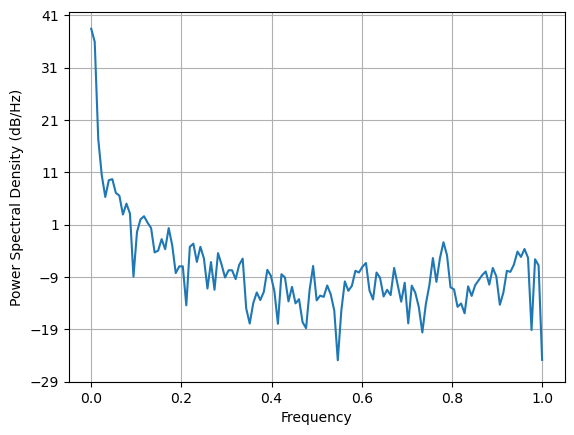

In [34]:
plt.psd(x=df.Revenue)

<p>We will also look into a decomposed time series</p>

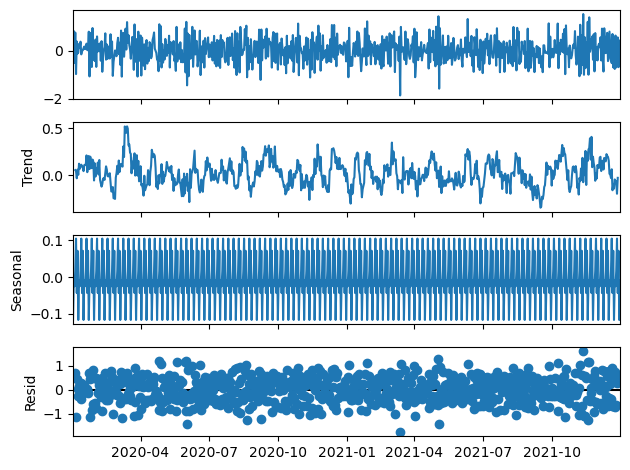

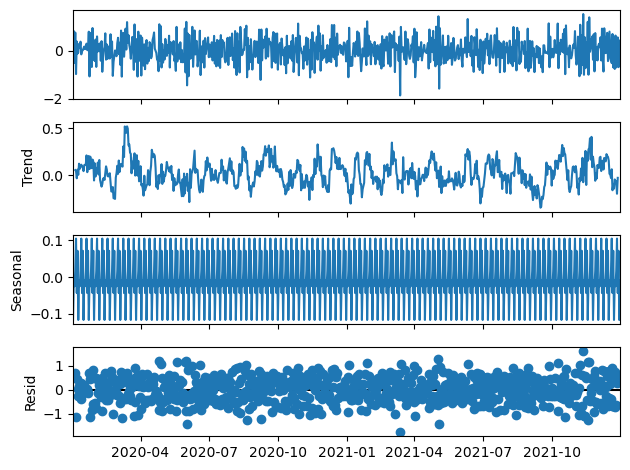

In [35]:
decomposed_df.plot()

Finally, we will confirm the lack of trends in the residuals of the decomposed series.</p>

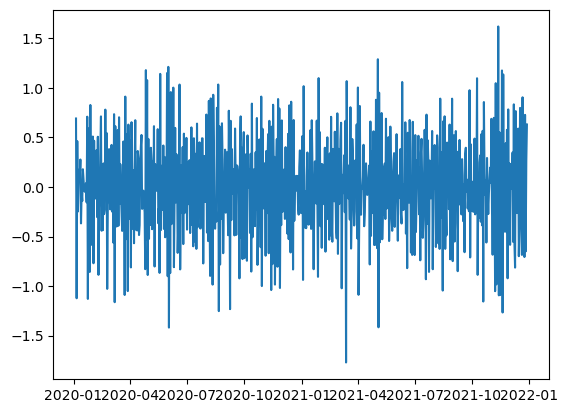

In [36]:
plt.plot(decomposed_df.resid)

<p>Clearly, the decomposed data does not contain any trends, and we are now ready to perform the analysis</p>
<h5>ARIMA Model Identification</h5>
<p>As mentioned when discussing the autocorrelation function, an AR(1) ARIMA model is best justified by the data provided.</p>

In [37]:
model = ARIMA(train, order=(1, 0, 0), freq='D')
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:           Revenue_Diff   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Fri, 14 Feb 2025   AIC                            773.893
Time:                        15:48:38   BIC                            787.002
Sample:                    01-02-2020   HQIC                           779.002
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.0

/usr/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<p>We have now created the ARIMA model, and it generates the following equation:</p>

In [38]:
ar_coef = result.arparams
ma_coef = result.maparams
intercept = result.params[0]
arima_equation = f"Revenue_Diff(t) = {intercept:.4f}"
for i, coef in enumerate(ar_coef, start=1):
    arima_equation += f" + ({coef:.4f}) * Revenue_Diff(t-{i})"
for i, coef in enumerate(ma_coef, start=1):
    arima_equation += f" + ({coef:.4f}) * e(t-{i})"

print("ARIMA Equation:")
print(arima_equation)

ARIMA Equation:
Revenue_Diff(t) = 0.0234 + (-0.4597) * Revenue_Diff(t-1)


/tmp/ipykernel_24837/3001692850.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = result.params[0]


<h5>Forecasting</h5>
<p>Now, we can attempt to use the model with the test dataset. This gives us 146 points of comparisons to check the predicted values against the actual values.</p>

2021-08-08   -0.048621
2021-08-09    0.056441
2021-08-10    0.008147
2021-08-11    0.030347
2021-08-12    0.020142
                ...   
2021-12-27    0.023356
2021-12-28    0.023356
2021-12-29    0.023356
2021-12-30    0.023356
2021-12-31    0.023356
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


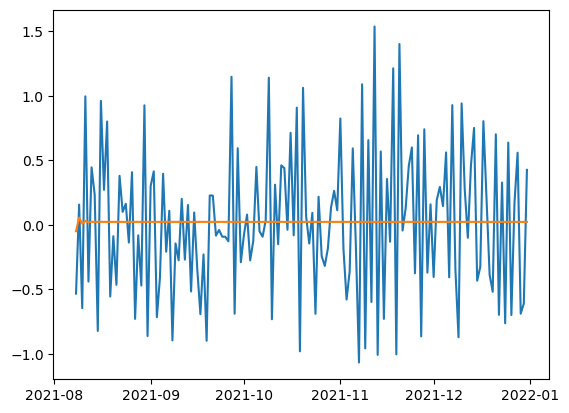

In [39]:
forecast = result.get_prediction(start = 584, end = 729, dynamic=True)
plt.plot(test)
plt.plot(forecast.predicted_mean)
print(forecast.predicted_mean)

<p>Obviously, we don't see a great ability to forecast the Revenue_Diff values with accuracy. However, it is important to keep in mind that this is not a prediction of the overall revenue of the telecommunications company. We are instead attempting to chart the daily revenue change. As such, the model is predicting a gradual growth in revenue, being slightly above 0. To evaluate the overall forecasting effectiveness of the model, we can revert the change to see how the predicted revenue charts against the actual revenue.</p>

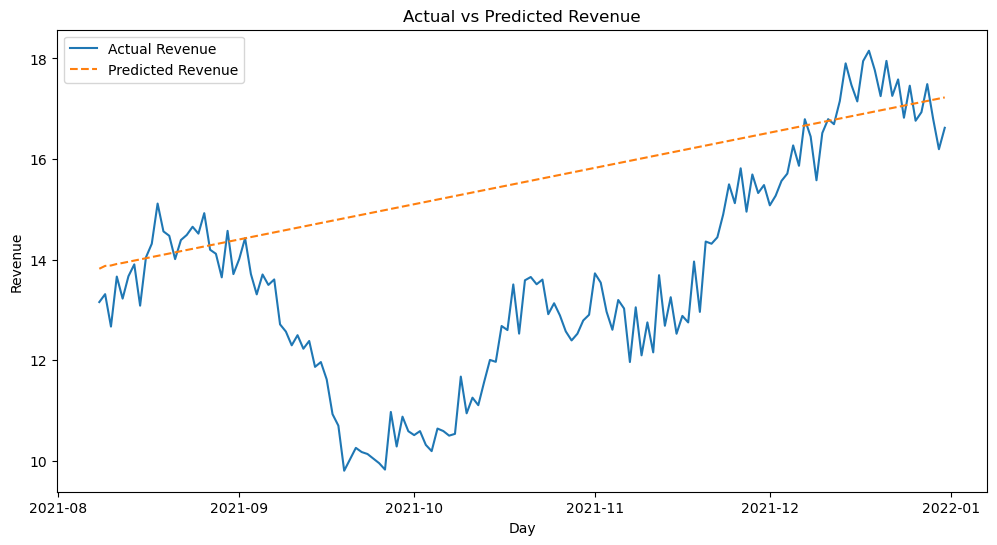

In [40]:
# Extract the last 20% of the entries from the df dataframe
last_20_percent = df.iloc[-len(test):]

# Initialize the predicted revenue with the last known revenue from the training set
predicted_revenue = [train['Revenue_Diff'].iloc[-1] + df['Revenue'].iloc[len(train)]]

# Calculate the predicted revenue using the forecasted day-over-day revenue change
for change in forecast.predicted_mean:
    predicted_revenue.append(predicted_revenue[-1] + change)

# Remove the initial value used for initialization
predicted_revenue = predicted_revenue[1:]

# Plot the actual and predicted revenue
plt.figure(figsize=(12, 6))
plt.plot(last_20_percent['Day'], last_20_percent['Revenue'], label='Actual Revenue')
plt.plot(last_20_percent['Day'], predicted_revenue, label='Predicted Revenue', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()
plt.show()

<p>Above, we can see the results of attempting to predict the revenue generated by the company. The data has accurate values around the beginning and the end of the dataset, but completely fails to predict the drastic decline that occured in September and October of 2021. We also have the ability to look at other factors, such as the MSE, to analyze the performance of the model</p>

Mean Squared Error: 6.767153609344741


<Figure size 1500x1500 with 0 Axes>

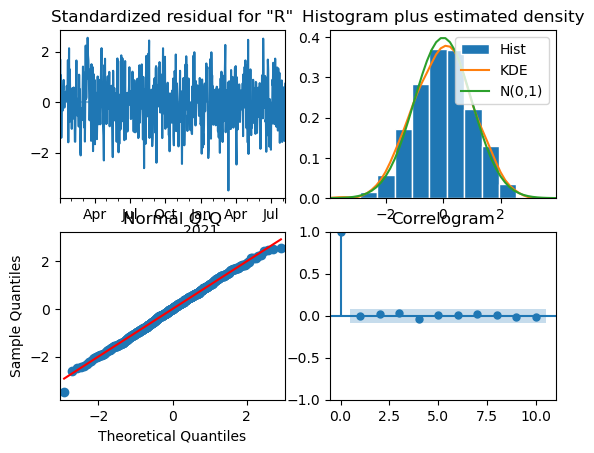

In [41]:
plt.figure(figsize = [15,15])
result.plot_diagnostics()
mse = mean_squared_error(last_20_percent['Revenue'], predicted_revenue)
print(f"Mean Squared Error: {mse}")

<h5>Output and Calculations</h5>
<p>All outputs are made available in the above sections</p>
<h5>Code</h5>
<p>All of the code to generate this model is provided in the above sections</p>
<h4 id="E">Summary and Implications</h4>
<h5>Results</h5>
<p>As described in the description of the ACF and PACF functions, the data in this model is best suited to an AR(1) model, given the ACF only having significant results until 2 and the PACF only having 1 significant result. This means that the ARIMA model's order would be (1, 0, 0). Once this model is created, we get an ARIMA equation, which is as follows:
Revenue_Diff(t) = 0.0234 + (-0.4597) * Revenue_Diff(t-1)
The prediction intervel of the foreecast is made with the last 20% of the dataset, consisting of 146 days (just below 5 months) at the end of 2021.
A fact worth noting is that the model begins and ends with accurate data over this 20%, but is inaccurate in the intermediate. As such, this anomaly makes me wonder what would happen if we had more data. It is possible that the model is capable of accurately predicting the change in revenue over longer periods of time, but does not specifically account for months of decreased revenue, merely factoring them into a mean monthly growth. As such, the model may be able to predict the average rate of growth over long periods of time, but be unreliable at predicting the growth within smaller time frames.
The length of the forecast is sizable, and not necessarily well-suited for general business purposes. Most businesses are more concerned with potential revenue over the course of the next 2-3 months, assuming that performing well consistently within these months amounts to large-scale profits over time. As such, having a model that can only accurately predict the revenue over the course of 5 months as in the test, or in years, as it would likely take for the model to be accurate, would be unwise, and not likely to create value for the business.
The primary metric I would use to evaluate the model would be the mean-squared error, or MSE. As calculated above, we have an MSE of 6.77. Given the range of our values, between 10-18, this MSE indicates a generally bad performance. The model does not have significant accuracy in predicting revenue. As such, it would not be recommendable to rely upon the results of this analysis.</p>
<h5>Annotated Visualization</h5>
<p>Below, we can see the overall data, including the attempted forecast from the ARIMA model</p>


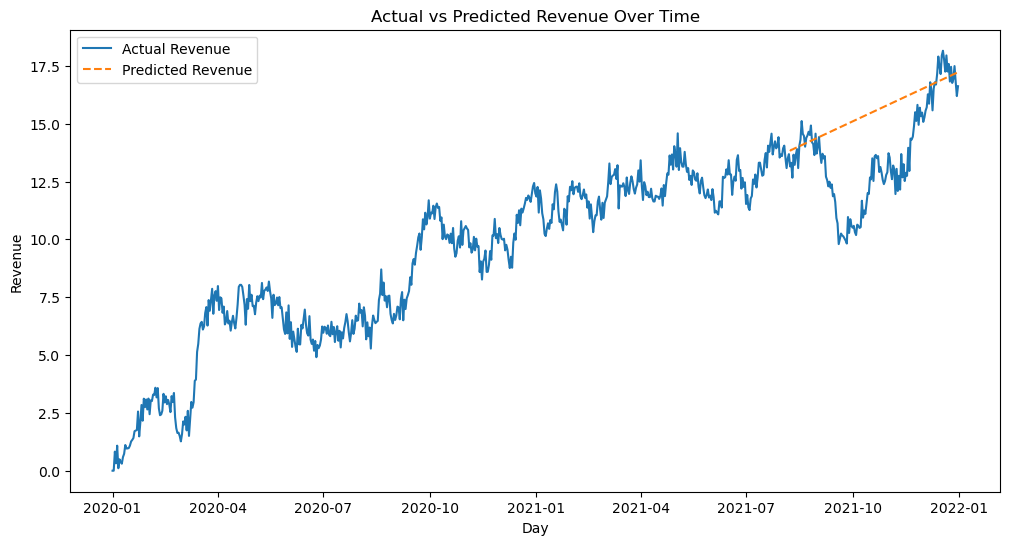

In [42]:
last_20_percent = df.iloc[-len(test):]

predicted_revenue = [train['Revenue_Diff'].iloc[-1] + df['Revenue'].iloc[len(train)]]

for change in forecast.predicted_mean:
    predicted_revenue.append(predicted_revenue[-1] + change)

predicted_revenue = predicted_revenue[1:]

# Plot the actual and predicted revenue
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Revenue'], label='Actual Revenue')
plt.plot(last_20_percent['Day'], predicted_revenue, label='Predicted Revenue', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue Over Time')
plt.legend()
plt.show()

<p>As already discussed, the end and beginning of the prediction approximately line up, but the ARIMA model is poorly suited to predict drops in revenue, meaning the analysis is not significantly more useful than a trend line</p>
<h5>Recommended Course of Action</h5>
<p>The poor performance of this model in the test dataset indicates that this model is not recommendable in future analysis. In terms of the recommended actions that I would have the business take, the first action that I would say is to be aware that the model is correct in the general trend, so we can have a fairly high degree of confidence that, even should the business suffer economic hardship in the future, as it did during the test set, that the business is also likely to see a resurgence, as it did at the end of 2021. More importantly, I would recommend that the business collect data that allows the information to be broken down on more specific factors. If we could analyze this data on the basis of geographic region or phone release schedules, then we may be able to provide predictions that have a higher degree of accuracy, predicting these downturns as well as the general overall growth. As such, my primary recommendation is to focus on acquiring data that can provide a more comprehensive picture of the industry, rather than making predictions solely on the basis of time.</p>
<h4 id="F">Reporting</h4>
<p>This data is compiled in a single Jupyter Notebook (.ipynb) file, consistent with the requirements listed in the rubric.
<h4 id="G">Code References</h4>
<p><a href="https://www.geeksforgeeks.org/plot-the-power-spectral-density-using-matplotlib-python/">Geeks for Geeks tutorial</a> was used for the creation of the PSD graph<br />
<a href="https://app.datacamp.com/learn/custom-tracks/custom-advanced-data-analytics">DataCamp tutorial </a>was used as a source of the code for the data preparation and ARIMA analysis</p>
<h4 id="H">Source References</h4>
<p><a href="https://app.datacamp.com/learn/custom-tracks/custom-advanced-data-analytics">DataCamp tutorial</a> was used to understand the purpose and use of time analysis, and to determine the type of AR model to use</p>